***Preface***

*Some of the text here has been taken from DataFest and the American Statistical Association.

DataFest was founded at UCLA in 2011, when 30 students gathered for 48 intense hours to analyze five years of arrest records provided by Lt. Thomas Zak of the Los Angeles Police Department. ASA DataFest is now sponsored by the American Statistical Association and hosted by several of the most prestigious colleges and universities in the country. More than 2000 students take part from schools such as UCLA, Pomona College, Cal Poly San Luis Obispo, UC Riverside, University of Southern California, Purdue University, Duke, the University of North Carolina, North Carolina State, Emory, Princeton, Dartmouth, Smith, Hampshire, Amherst, Mt. Holyoke, and the University of Massachusetts.

Elm City Stories is an educational video game designed for middle and high school students.  The game was developed for researchers at the Play2Prevent Lab within the Yale School of Medicine. The overall goal for the designers of the game is to prevent negative health outcomes such as HIV, sexually transmitted infections, and substance misuse in young at-risk teens (ages 11-14 years) by increasing their perception of risk and acquiring healthy skills to prevent engaging in risky behavior. A key component to this change is a set of skills that allow teens to      predict and understand future consequences of actions

***The Question***

The challenge in this DataFest is to help the researchers who created Elm City Stories to see if their game might be useful in understanding real-life behavior.  To do this, they're asking you to try to characterize, measure, observe, and display patterns of play within the game.  One goal for future games is to design them so that the games produce real-time data that is useful to psychology researchers. Your answers will help the Play2Prevent Lab researchers better understand what types of data this might be.

Unfortunately, we are unable to publish the dataset we were given at the request of the publishers.

***Introduction***

After playing through the game we quickly lost interest. We figured that if we did not have the patience to play through the game as college students, there's a good chance that many middle schoolers forced to play this game for money would likely not be interested either. Before spending a lot of time digging through the data, we wanted to ensure that our hypothesis would likely be correct by gauging other DataFest students whether they would have played through the game as a middle schooler as well, to which ~80% responded no. It would be hard to come to useful conclusions with this dataset given that many students probably are not "good" participants, creating a bit of sampling bias.

***Exploration and Filtering***

In [54]:
#importing relevant modules for future use
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import seaborn as sns

In [55]:
# load the data
logs = pd.read_csv('/Users/wiggles/Desktop/DATAFEST2022/DA DRIVE/data files/logs.csv')

/Users/wiggles/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (34,38,39,40,47,50,53,54,57,58,59,60,62,68,70,72,73,74,76,77,78,81,85,88,89,90,91,92,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,118,120,121,122,123,129,131) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [56]:
#creates a list a dataframes, each representing a single player's full playthrough
df_players = []
for i in logs['player_id'].unique():
    df_players.append(logs[logs['player_id'] == i])

Within the first 10 minutes of the game, players are asked to pick words to describe their goals, themselves, their family, etc. Since this is an early part of the game, all players should reach this point and we suspect that the words they choose should be some indicator as to their initial interest in the game.

In [57]:
#creates a list of lists, with each list representing each players word choice
wordchoice = []
for i in df_players:
    wordchoice.append(i['old_label'].dropna())

Below are examples of some player inputs.

In [58]:
for i in range(6):
    print(wordchoice[i])

3638    Actor
Name: old_label, dtype: object
Series([], Name: old_label, dtype: object)
22050    joyful
Name: old_label, dtype: object
37338    smart
Name: old_label, dtype: object
38408    family
45620    sciene
51084     india
Name: old_label, dtype: object
Series([], Name: old_label, dtype: object)


Here, we created a boolean mask in order to filter "good" responses from "bad" responses. Here we automatically filtered out players that had no input and players that had inputs as True and False. We also manually corrected some inputted values as "bad" because some players simply typed out innappropriate words or gibberish. This could be automatically filtered out using NLP in future iterations, but we decided against spending time to create such a model given the tight time constraints.

In [70]:
mask = []
for i in w:
    if len(i) == 0: #checks if responses even exist
        mask.append(False)
    else:
        mask.append(True)
trueIndices = []
for i in range(len(mask)):
    if mask[i]:
        trueIndices.append(i)
trueIndicesNonValid = [16, 29, 33, 42, 98, 100] #players w "bad" responses
nonValid = []
for i in trueIndicesNonValid:
    nonValid.append(trueIndices[i])

# nonValid
for i in nonValid:
    mask[i] = not mask[i]

In [71]:
caregroup = []
notcaregroup = []
for i in range(len(mask)):
    if mask[i]:
        caregroup.append(df_players[i])
    else:
        notcaregroup.append(df_players[i])

The next block of code filters out all players with total time spent greater than 16 hours played. Due to some errors in the way the time was recorded for some players, a few had hours upwards of 80. The documentation claims players played the game for around 1-12 hours, so we decided to give room for leeway. This filter should have probably been used at the beginning, but we were not aware of it until we were near finished with the data.

In [72]:
caregroup_u16 = []
for i in range(len(caregroup)):
    if caregroup[i]['event_time_dbl'].max() <= 57600:
        caregroup_u16.append(caregroup[i])

notcaregroup_u16 = []
for i in range(len(notcaregroup)):
    if notcaregroup[i]['event_time_dbl'].max() <= 57600:
        notcaregroup_u16.append(notcaregroup[i])

In [88]:
'''creates a list of total time completed converted into hours'''
def hours(care_group): 
    total_hours = []
    for i in care_group:
        total_hours.append(i['event_time_dbl'].max()/3600)
    return total_hours
caregroup_hours_spent = hours(caregroup_u16)
notcaregroup_hours_spent = hours(notcaregroup_u16)

In [89]:
'''creates a list of final proportion of game completed'''
def prop(care_group): 
    prop = []
    for i in care_group:
        prop.append(i['proportion_complete'].max())
    return prop
caregroup_prop = prop(caregroup_u16)
notcaregroup_prop = prop(notcaregroup_u16)

***Graphs***

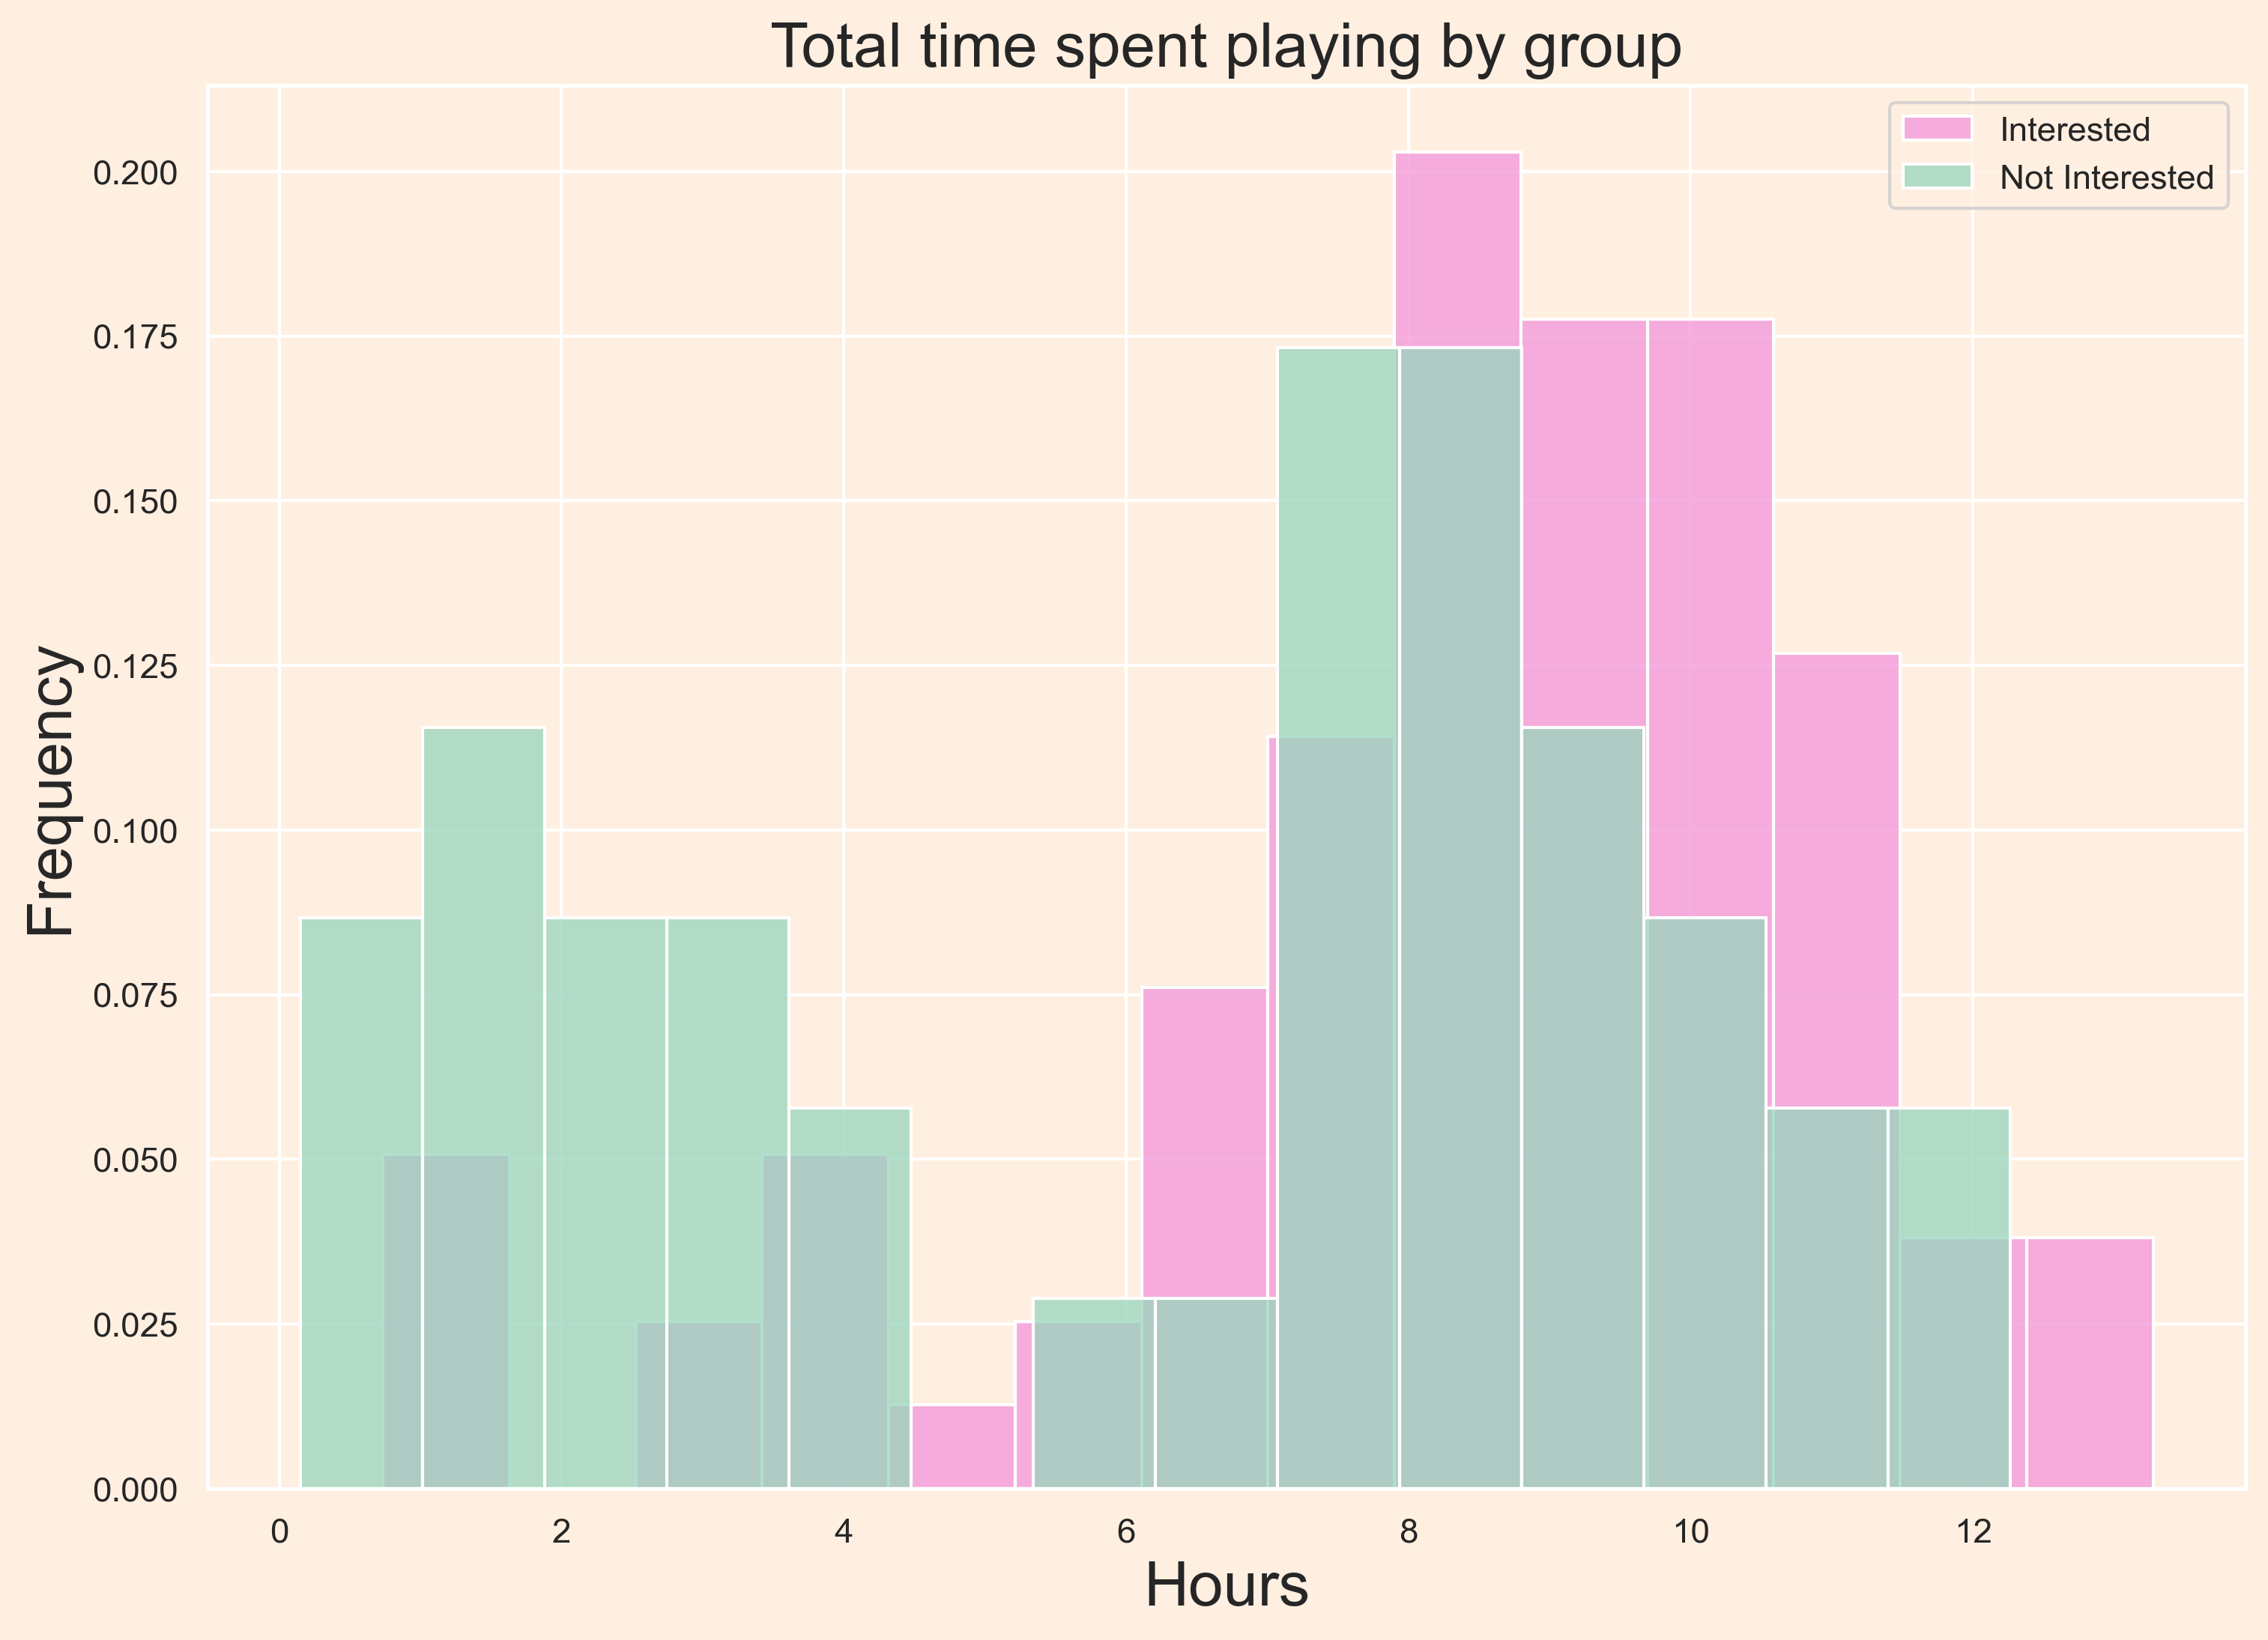

In [91]:
'''creates a histogram of the total amount of time spent by each group overlayed on top of each other'''
fig, ax = plt.subplots()
sns.histplot(x=caregroup_hours_spent, color = '#f294d9', stat = 'density', bins = 14)
sns.histplot(x=notcaregroup_hours_spent, color = '#97d5bc', stat = 'density', bins = 14)
sns.set(rc={'axes.facecolor':'#ffefe1', 'figure.facecolor':'#ffefe1', 'figure.figsize':(11.7,8.27)})
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
ax.set_xlabel("Hours", fontsize = 20)
ax.set_ylabel("Frequency", fontsize = 20)
ax.set_title("Total time spent playing by group", fontsize = 20)
plt.legend(labels=["Interested","Not Interested"])
ax.grid = False

In [94]:
stats.ttest_ind(caregroup_hours_spent, notcaregroup_hours_spent, equal_var = False)

Ttest_indResult(statistic=3.2800487410039767, pvalue=0.0017180054292720468)

Based on this graph, you can notice that the "not interested" group seems to spend much less time than "interested" group. This is supported by a T-test which gives us a p-vaue of 0.0017180054292720468.

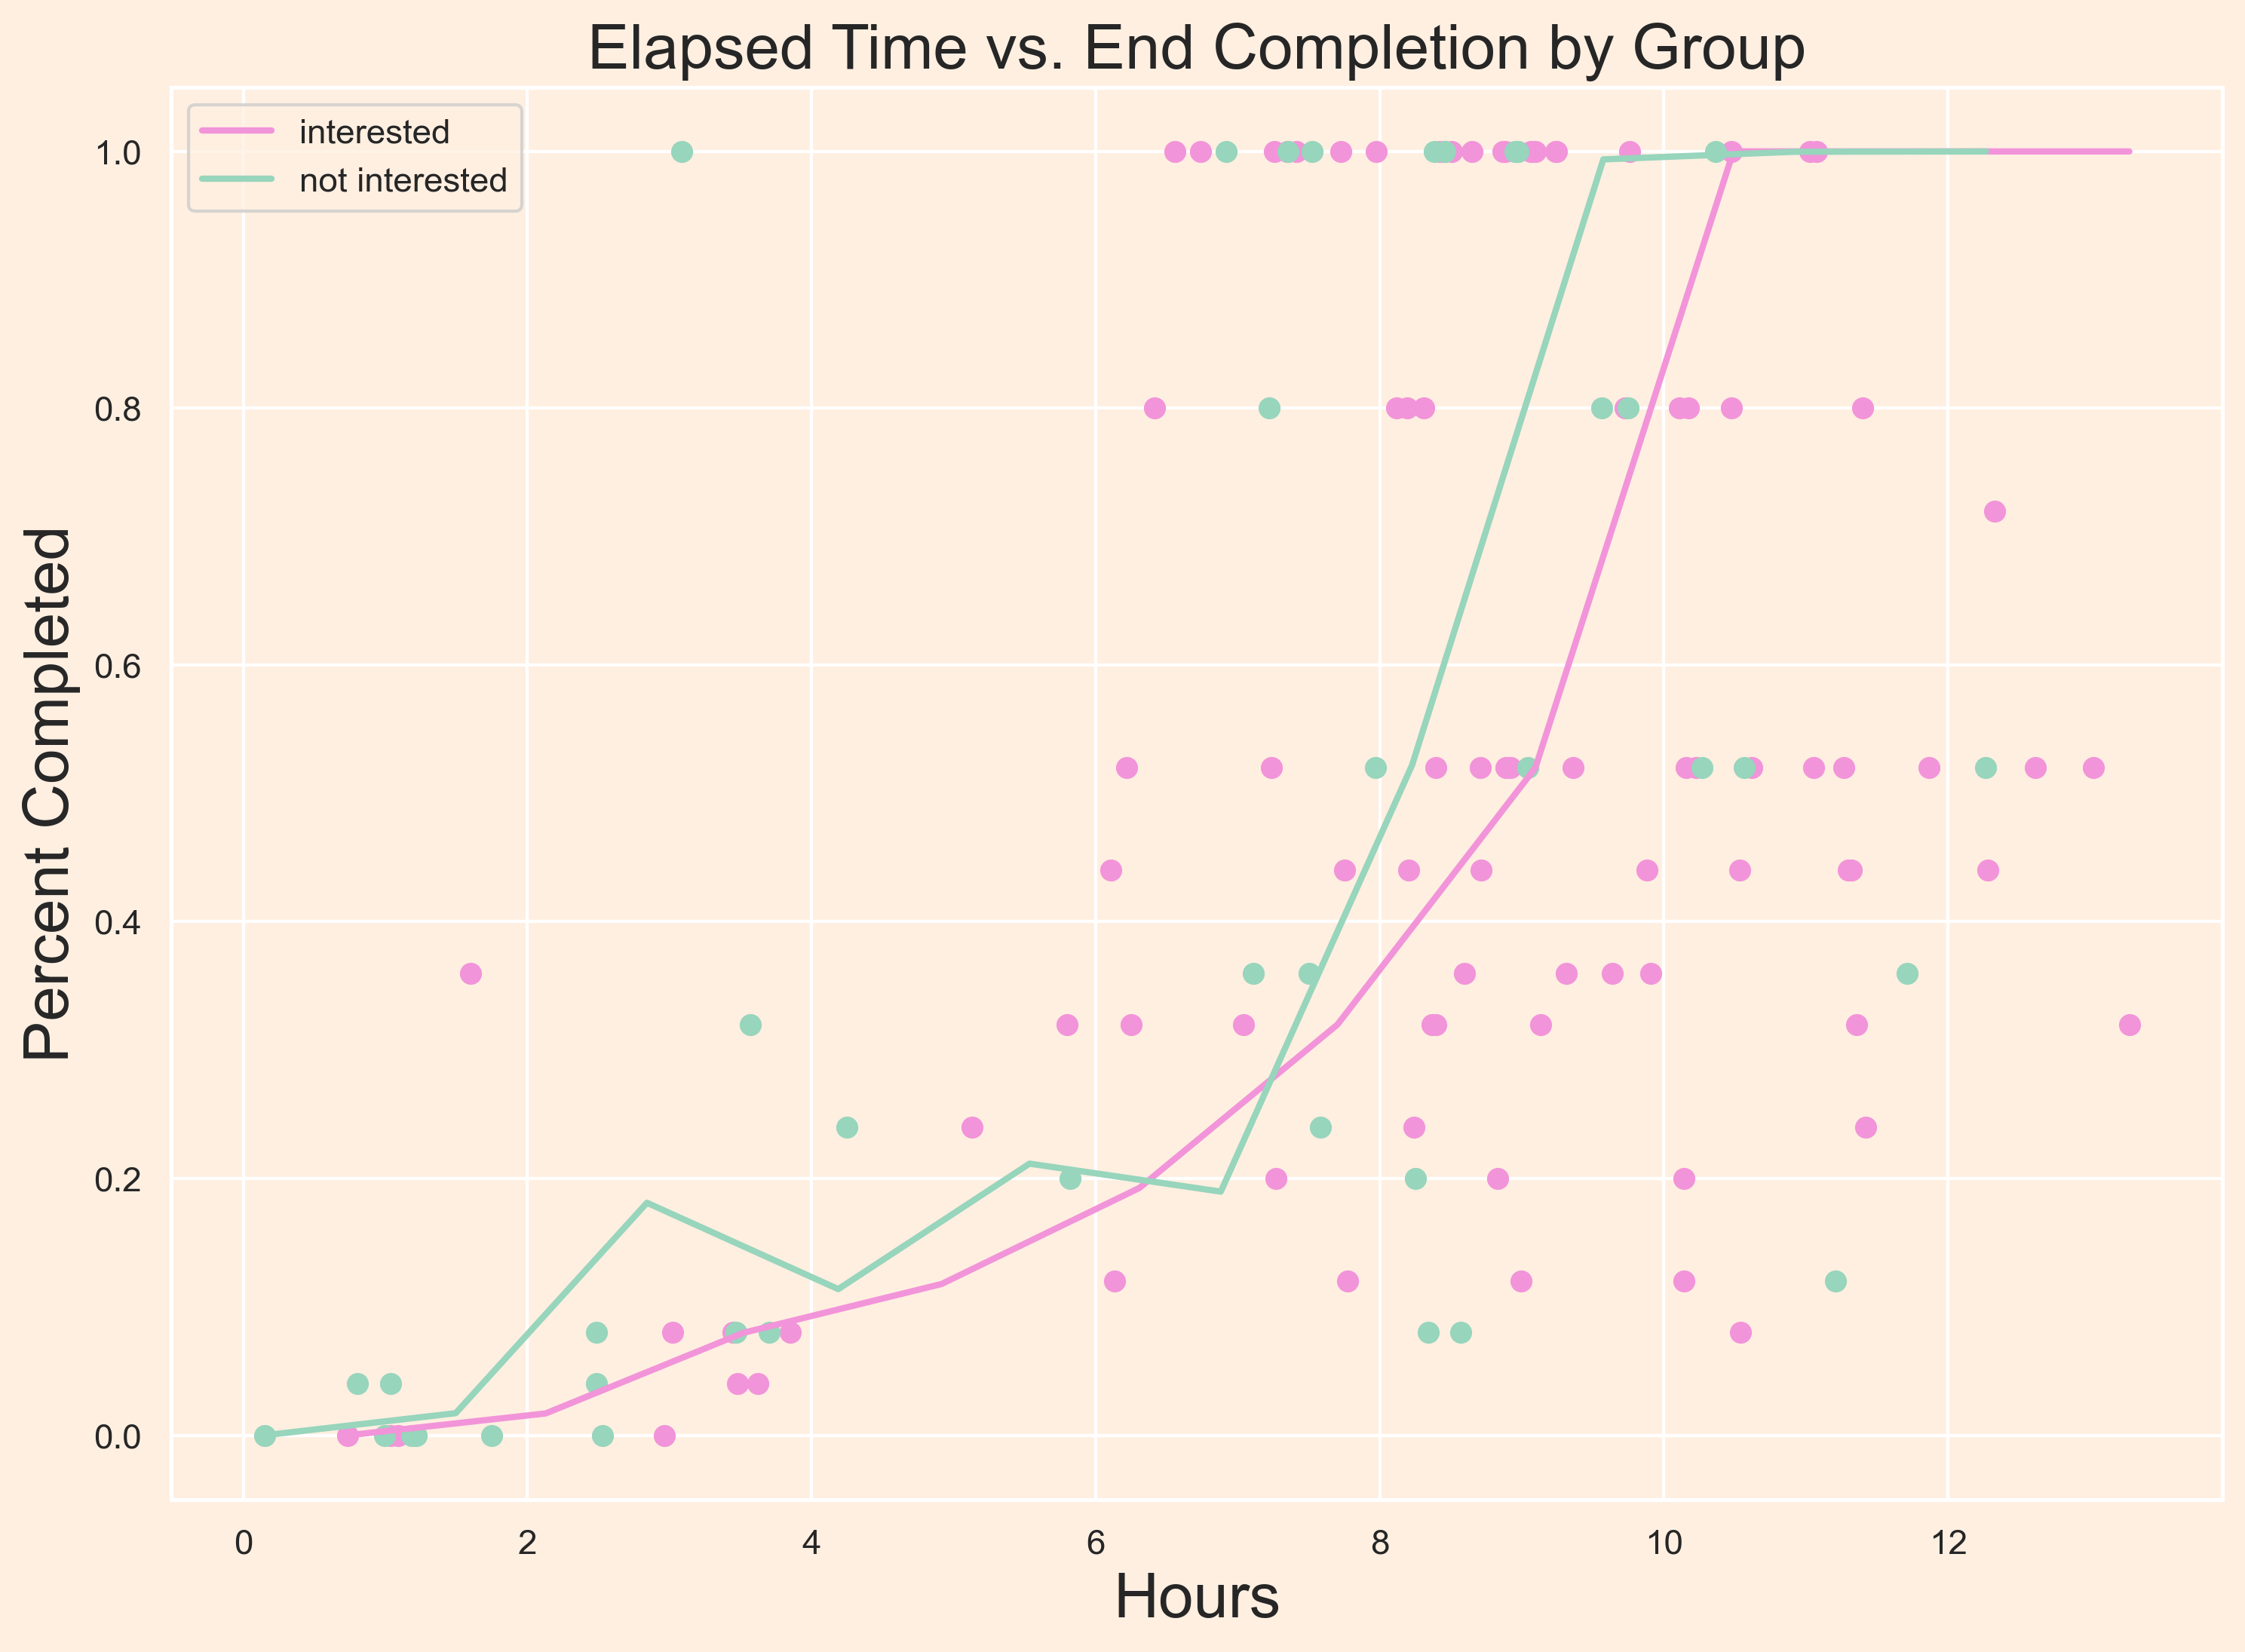

In [92]:
'''Creates a scatterplot of the final amount of time spent on the game in comparison to the final proportion of the game completed along with a line of best fit'''
from scipy.interpolate import make_interp_spline

X_Y_Spline_c = make_interp_spline(np.sort(caregroup_hours_spent), np.sort(caregroup_prop))

X_c = np.linspace(min(caregroup_hours_spent), max(caregroup_hours_spent), 10)
Y_c = X_Y_Spline_c(X_c)

X_Y_Spline_n = make_interp_spline(np.sort(notcaregroup_hours_spent), np.sort(notcaregroup_prop))

X_n = np.linspace(min(notcaregroup_hours_spent), max(notcaregroup_hours_spent), 10)
Y_n = X_Y_Spline_n(X_n)

fig, ax = plt.subplots()
ax.set_title("Total time spent playing by group", fontsize = 20)
ax.grid = False
plt.plot(X_c, Y_c, linewidth = 2, color = '#f294d9')
plt.plot(X_n, Y_n, linewidth = 2, color = '#97d5bc')
plt.scatter(caregroup_hours_spent, caregroup_prop, color = '#f294d9')
plt.scatter(notcaregroup_hours_spent, notcaregroup_prop, color = '#97d5bc')
plt.legend(['interested', 'not interested'], loc = "upper left")
plt.xlabel('Hours', fontsize = 20)
plt.ylabel('Percent Completed', fontsize = 20)
plt.title('Elapsed Time vs. End Completion by Group', fontsize = 20)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
sns.set(rc={'axes.facecolor':'#ffefe1', 'figure.facecolor':'#ffefe1', 'figure.figsize':(11.7,8.27)})
plt.show()

From these graph lines you can see that the not interested group tend to take less time to make the same amount of progress on the game. Another interesting thing from this graph, is the large amount of players that drop off at the halfway mark, followed by a period of time in which almost no players drop off.

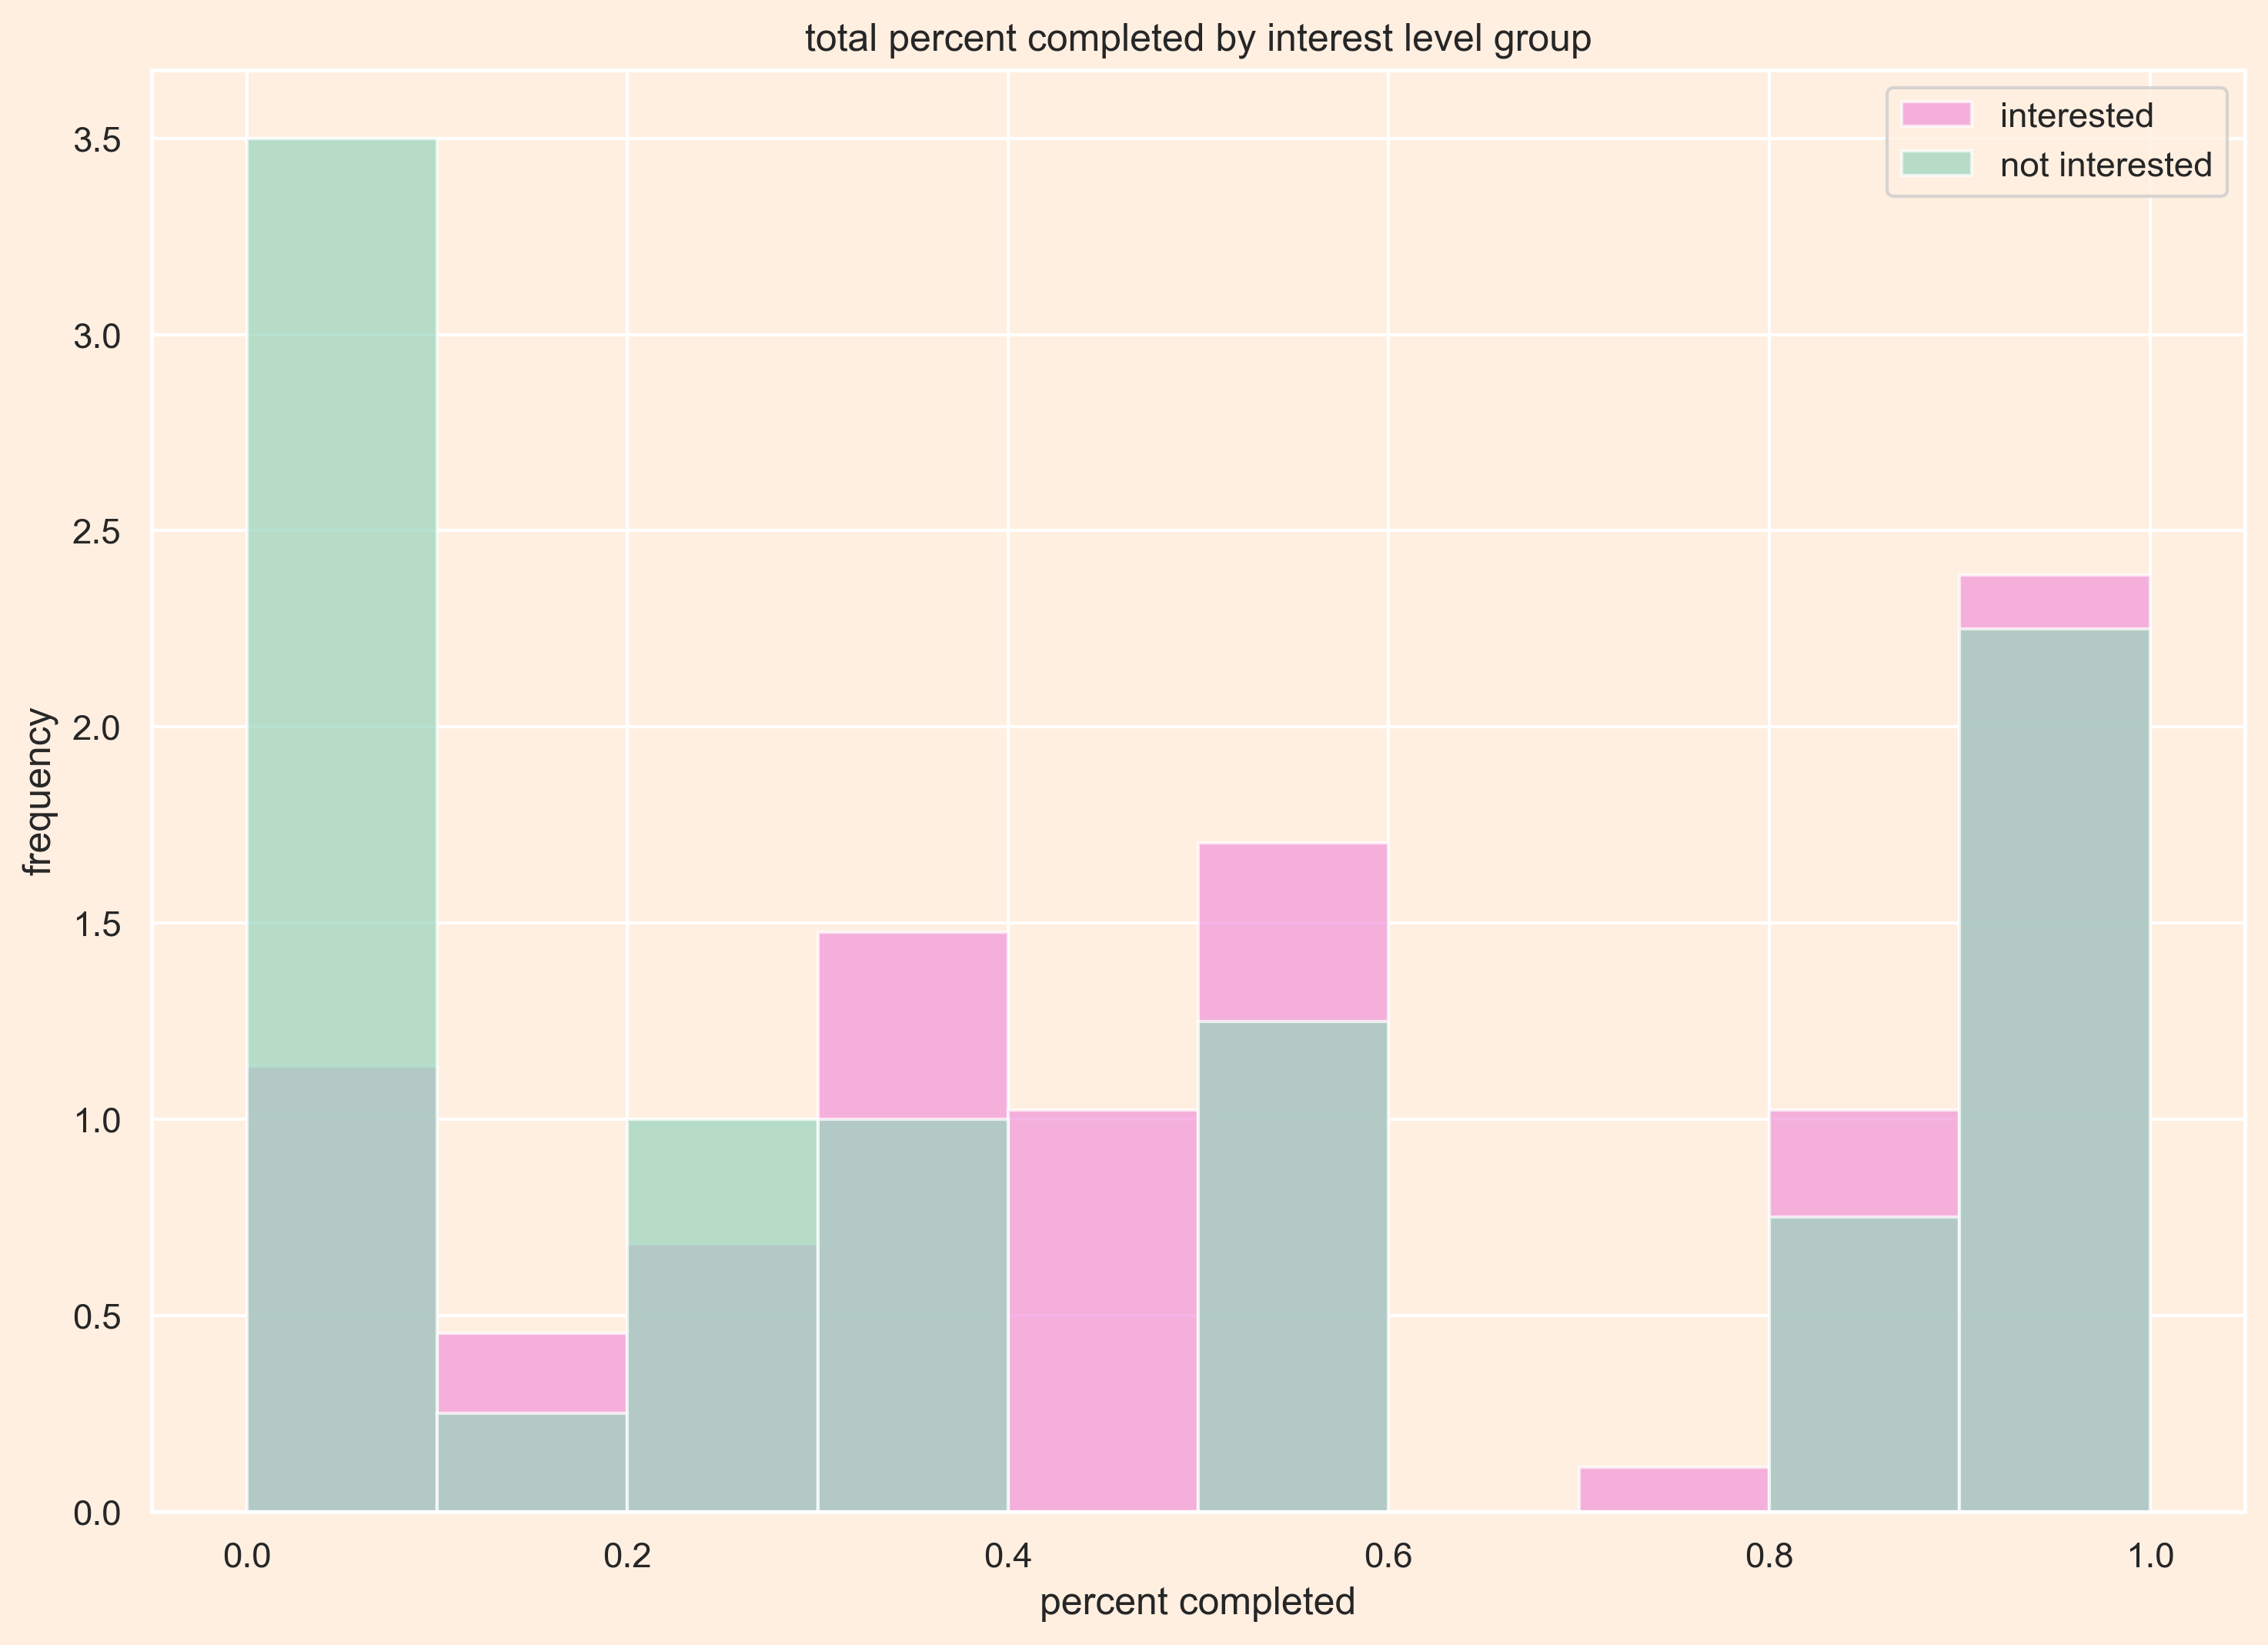

In [93]:
'''creates a histogram of final percent completed'''
plt.hist(caregroup_prop, density = True, bins = 10, alpha = 0.7, color = '#f294d9')
plt.hist(notcaregroup_prop, density = True, bins = 10, alpha = 0.7, color = '#97d5bc')
plt.legend(['interested', 'not interested'])
plt.xlabel('percent completed')
plt.ylabel('frequency')
plt.title('total percent completed by interest level group')
plt.show()

In [95]:
stats.ttest_ind(caregroup_prop, notcaregroup_prop, equal_var = False)

Ttest_indResult(statistic=1.6095084730337983, pvalue=0.11227723530853016)

While the histogram appears to be very different at the beginning between interested and non-interested groups, our p-value was ~.11. For this reason, we decided not to use this graph in our end presentation.

***Conclusion***

Based on the first graph, we can see that our method of evaluating player interest is effective as the dividing the groups based on the early indicator of "good" vs "bad" responses creates a meaningful difference in the amount of time players spend on the game, with players with "bad" responses ending up with much less hours played.

This could be a useful tool for future analysis of the data, as a researcher could use the change in proportion of interested and non-interested players in the game as a measurement of if their improvements of the game increase player engagement. Researchers could also put more of these player input checks within the game to see what parts of the game players tend to lose interest in. Another way in which this data could be used would be for researchers to only take data from the "interested" group, as the impact it has on players is probably much more meaningful/noticable.

We do acknowledge that our seperation of good and bad responses could be improved by a NLP model in future iterations.

The second graph, shows that players struggle to make it past halfway through the game with more than half dropping out beforehand, and many dropping out at exactly the halfway point. A recommendation our research team has made for improvement could be to perhaps split the game into smaller parts to retain player engagement. With many of the players continuing to the end after making it past the halfway point could be an indicator as to the notion that the latter half of the game is perhaps more interesting than the first half, probably based off topics alone. We recommend that researchers try to mimic parts of the latter half of the game more in the first half.

 Regardless, both groups end up speeding up through the game as they progress, as it takes them less time to complete a greater proportion of the game as they continue, as indicative of the exponential line of both groups on graph 2. This could be an indicator of lack of player interest as they continue, or perhaps players are more comfortable with the game as they progress through it. If the latter statement were true, perhaps a solution to player interest would be to make the game more approachable at the beginning.

P.S.

Our presentation won The Best Insight Award.